# Manipulating and Cleaning Data

Real-world data is messy. You will likely need to combine several data sources to get the data you actually want. The data from those sources will be incomplete. And it will likely not be formatted in exactly the way you want in order to perform your analysis. It's for these reasons that most data scientists will tell you that about 80 percent of any project is spent just getting the data into a form ready for analysis.

## Exploring `DataFrame` information

Once you have loaded your data into pandas, it will more likely than not be in a `DataFrame`. However, if the data set in your `DataFrame` has 60,000 rows and 400 columns, how do you even begin to get a sense of what you're working with? Fortunately, pandas provides some convenient tools to quickly look at overall information about a `DataFrame` in addition to the first few and last few rows.

In order to explore this functionality, we will import the Python scikit-learn library and use an iconic dataset that every data scientist has seen hundreds of times: British biologist Ronald Fisher's *Iris* data set used in his 1936 paper "The use of multiple measurements in taxonomic problems":

In [1]:
!pip install pandas scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])

### `DataFrame.info`
Let's take a look at this dataset to see what we have:

In [3]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


From this, we know that the *Iris* dataset has 150 entries in four columns. All of the data is stored as 64-bit floating-point numbers.

### `DataFrame.head`
Next, let's see what the first few rows of our `DataFrame` look like:

In [4]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Exercise:

By default, `DataFrame.head` returns the first five rows of a `DataFrame`. In the code cell below, can you figure out how to get it to show more?

In [5]:
# Hint: Consult the documentation by using iris_df.head?


### `DataFrame.tail`
The flipside of `DataFrame.head` is `DataFrame.tail`, which returns the last five rows of a `DataFrame`:

In [6]:
iris_df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3
149,5.9,3.0,5.1,1.8


In practice, it is useful to be able to easily examine the first few rows or the last few rows of a `DataFrame`, particularly when you are looking for outliers in ordered datasets.

> **Takeaway:** Even just by looking at the metadata about the information in a DataFrame or the first and last few values in one, you can get an immediate idea about the size, shape, and content of the data you are dealing with.

## Dealing with missing data

Most of the time the datasets you want to use (of have to use) have missing values in them. How missing data is handled carries with it subtle tradeoffs that can affect your final analysis and real-world outcomes.

Pandas handles missing values in two ways. The first you've seen before in previous sections: `NaN`, or Not a Number. This is a actually a special value that is part of the IEEE floating-point specification and it is only used to indicate missing floating-point values.

For missing values apart from floats, pandas uses the Python `None` object. While it might seem confusing that you will encounter two different kinds of values that say essentially the same thing, there are sound programmatic reasons for this design choice and, in practice, going this route enables pandas to deliver a good compromise for the vast majority of cases. Notwithstanding this, both `None` and `NaN` carry restrictions that you need to be mindful of with regards to how they can be used.

### `None`: non-float missing data
Because `None` comes from Python, it cannot be used in NumPy and pandas arrays that are not of data type `'object'`. Remember, NumPy arrays (and the data structures in pandas) can contain only one type of data. This is what gives them their tremendous power for large-scale data and computational work, but it also limits their flexibility. Such arrays have to upcast to the “lowest common denominator,” the data type that will encompass everything in the array. When `None` is in the array, it means you are working with Python objects.

To see this in action, consider the following example array (note the `dtype` for it):

In [7]:
import numpy as np

example1 = np.array([2, None, 6, 8])
example1

array([2, None, 6, 8], dtype=object)

The reality of upcast data types carries two side effects with it. First, operations will be carried out at the level of interpreted Python code rather than compiled NumPy code. Essentially, this means that any operations involving `Series` or `DataFrames` with `None` in them will be slower. While you would probably not notice this performance hit, for large datasets it might become an issue.

The second side effect stems from the first. Because `None` essentially drags `Series` or `DataFrame`s back into the world of vanilla Python, using NumPy/pandas aggregations like `sum()` or `min()` on arrays that contain a ``None`` value will generally produce an error:

In [8]:
# example1.sum()

**Key takeaway**: Addition (and other operations) between integers and `None` values is undefined, which can limit what you can do with datasets that contain them.

### `NaN`: missing float values

In contrast to `None`, NumPy (and therefore pandas) supports `NaN` for its fast, vectorized operations and ufuncs. The bad news is that any arithmetic performed on `NaN` always results in `NaN`. For example:

In [9]:
np.nan + 1

nan

In [10]:
np.nan * 0

nan

The good news: aggregations run on arrays with `NaN` in them don't pop errors. The bad news: the results are not uniformly useful:

In [11]:
example2 = np.array([2, np.nan, 6, 8]) 
example2.sum(), example2.min(), example2.max()

(np.float64(nan), np.float64(nan), np.float64(nan))

### Exercise:

In [12]:
# What happens if you add np.nan and None together?


Remember: `NaN` is just for missing floating-point values; there is no `NaN` equivalent for integers, strings, or Booleans.

### `NaN` and `None`: null values in pandas

Even though `NaN` and `None` can behave somewhat differently, pandas is nevertheless built to handle them interchangeably. To see what we mean, consider a `Series` of integers:

In [13]:
int_series = pd.Series([1, 2, 3], dtype=int)
int_series

0    1
1    2
2    3
dtype: int64

### Exercise:

In [14]:
# Now set an element of int_series equal to None.
# How does that element show up in the Series?
# What is the dtype of the Series?


In the process of upcasting data types to establish data homogeneity in `Seires` and `DataFrame`s, pandas will willingly switch missing values between `None` and `NaN`. Because of this design feature, it can be helpful to think of `None` and `NaN` as two different flavors of "null" in pandas. Indeed, some of the core methods you will use to deal with missing values in pandas reflect this idea in their names:

- `isnull()`: Generates a Boolean mask indicating missing values
- `notnull()`: Opposite of `isnull()`
- `dropna()`: Returns a filtered version of the data
- `fillna()`: Returns a copy of the data with missing values filled or imputed

These are important methods to master and get comfortable with, so let's go over them each in some depth.

### Detecting null values
Both `isnull()` and `notnull()` are your primary methods for detecting null data. Both return Boolean masks over your data.

In [15]:
example3 = pd.Series([0, np.nan, '', None])

In [16]:
example3.isnull()

0    False
1     True
2    False
3     True
dtype: bool

Look closely at the output. Does any of it surprise you? While `0` is an arithmetic null, it's nevertheless a perfectly good integer and pandas treats it as such. `''` is a little more subtle. While we used it in Section 1 to represent an empty string value, it is nevertheless a string object and not a representation of null as far as pandas is concerned.

Now, let's turn this around and use these methods in a manner more like you will use them in practice. You can use Boolean masks  directly as a ``Series`` or ``DataFrame`` index, which can be useful when trying to work with isolated missing (or present) values.

### Exercise:

In [17]:
# Try running example3[example3.notnull()].
# Before you do so, what do you expect to see?


**Key takeaway**: Both the `isnull()` and `notnull()` methods produce similar results when you use them in `DataFrame`s: they show the results and the index of those results, which will help you enormously as you wrestle with your data.

### Dropping null values

Beyond identifying missing values, pandas provides a convenient means to remove null values from `Series` and `DataFrame`s. (Particularly on large data sets, it is often more advisable to simply remove missing [NA] values from your analysis than deal with them in other ways.) To see this in action, let's return to `example3`:

In [18]:
example3 = example3.dropna()
example3

0    0
2     
dtype: object

Note that this should look like your output from `example3[example3.notnull()]`. The difference here is that, rather than just indexing on the masked values, `dropna` has removed those missing values from the `Series` `example3`.

Because `DataFrame`s have two dimensions, they afford more options for dropping data.

In [19]:
example4 = pd.DataFrame([[1,      np.nan, 7], 
                         [2,      5,      8], 
                         [np.nan, 6,      9]])
example4

,0,1,2
0,1.0,NaN,7
1,2.0,5.0,8
2,NaN,6.0,9


(Did you notice that pandas upcast two of the columns to floats to accommodate the `NaN`s?)

You cannot drop a single value from a `DataFrame`, so you have to drop full rows or columns. Depending on what you are doing, you might want to do one or the other, and so pandas gives you options for both. Because in data science, columns generally represent variables and rows represent observations, you are more likely to drop rows of data; the default setting for `dropna()` is to drop all rows that contain any null values:

In [20]:
example4.dropna()

,0,1,2
1,2.0,5.0,8


If necessary, you can drop NA values from columns. Use `axis=1` to do so:

In [21]:
example4.dropna(axis='columns')

,2
0,7
1,8
2,9


Notice that this can drop a lot of data that you might want to keep, particularly in smaller datasets. What if you just want to drop rows or columns that contain several or even just all null values? You specify those setting in `dropna` with the `how` and `thresh` parameters.

By default, `how='any'` (if you would like to check for yourself or see what other parameters the method has, run `example4.dropna?` in a code cell). You could alternatively specify `how='all'` so as to drop only rows or columns that contain all null values. Let's expand our example `DataFrame` to see this in action.

In [22]:
example4[3] = np.nan
example4

,0,1,2,3
0,1.0,NaN,7,NaN
1,2.0,5.0,8,NaN
2,NaN,6.0,9,NaN


### Exercise:

In [23]:
# How might you go about dropping just column 3?
# Hint: remember that you will need to supply both the axis parameter and the how parameter.


The `thresh` parameter gives you finer-grained control: you set the number of *non-null* values that a row or column needs to have in order to be kept:

In [24]:
example4.dropna(axis='rows', thresh=3)

,0,1,2,3
1,2.0,5.0,8,NaN


Here, the first and last row have been dropped, because they contain only two non-null values.

### Filling null values

Depending on your dataset, it can sometimes make more sense to fill null values with valid ones rather than drop them. You could use `isnull` to do this in place, but that can be laborious, particularly if you have a lot of values to fill. Because this is such a common task in data science, pandas provides `fillna`, which returns a copy of the `Series` or `DataFrame` with the missing values replaced with one of your choosing. Let's create another example `Series` to see how this works in practice.

In [25]:
example5 = pd.Series([1, np.nan, 2, None, 3], index=list('abcde'))
example5

a    1.0
b    NaN
c    2.0
d    NaN
e    3.0
dtype: float64

You can fill all of the null entries with a single value, such as `0`:

In [26]:
example5.fillna(0)

a    1.0
b    0.0
c    2.0
d    0.0
e    3.0
dtype: float64

### Exercise:

In [27]:
# What happens if you try to fill null values with a string, like ''?


You can **forward-fill** null values, which is to use the last valid value to fill a null:

In [28]:
example5.fillna(method='ffill')

/var/folders/p1/d1ynn_dj70gb669w1pst351m0000gn/T/ipykernel_90408/3194571100.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  example5.fillna(method='ffill')


a    1.0
b    1.0
c    2.0
d    2.0
e    3.0
dtype: float64

You can also **back-fill** to propagate the next valid value backward to fill a null:

In [29]:
example5.fillna(method='bfill')

/var/folders/p1/d1ynn_dj70gb669w1pst351m0000gn/T/ipykernel_90408/2679643382.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  example5.fillna(method='bfill')


a    1.0
b    2.0
c    2.0
d    3.0
e    3.0
dtype: float64

As you might guess, this works the same with `DataFrame`s, but you can also specify an `axis` along which to fill null values:

In [30]:
example4

,0,1,2,3
0,1.0,NaN,7,NaN
1,2.0,5.0,8,NaN
2,NaN,6.0,9,NaN


In [31]:
example4.fillna(method='ffill', axis=1)

/var/folders/p1/d1ynn_dj70gb669w1pst351m0000gn/T/ipykernel_90408/841513876.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  example4.fillna(method='ffill', axis=1)


,0,1,2,3
0,1.0,1.0,7.0,7.0
1,2.0,5.0,8.0,8.0
2,NaN,6.0,9.0,9.0


Notice that when a previous value is not available for forward-filling, the null value remains.

### Exercise:

In [32]:
# What output does example4.fillna(method='bfill', axis=1) produce?
# What about example4.fillna(method='ffill') or example4.fillna(method='bfill')?
# Can you think of a longer code snippet to write that can fill all of the null values in example4?


You can be creative about how you use `fillna`. For example, let's look at `example4` again, but this time let's fill the missing values with the average of all of the values in the `DataFrame`:

In [33]:
example4.fillna(example4.mean())

,0,1,2,3
0,1.0,5.5,7,NaN
1,2.0,5.0,8,NaN
2,1.5,6.0,9,NaN


Notice that column 3 is still valueless: the default direction is to fill values row-wise.

> **Takeaway:** There are multiple ways to deal with missing values in your datasets. The specific strategy you use (removing them, replacing them, or even how you replace them) should be dictated by the particulars of that data. You will develop a better sense of how to deal with missing values the more you handle and interact with datasets.

## Removing duplicate data

In addition to missing data, you will often encounter duplicated data in real-world datasets. Fortunately, pandas provides an easy means of detecting and removing duplicate entries.

### Identifying duplicates: `duplicated`

You can easily spot duplicate values using the `duplicated` method in pandas, which returns a Boolean mask indicating whether an entry in a `DataFrame` is a duplicate of an ealier one. Let's create another example `DataFrame` to see this in action.

In [34]:
example6 = pd.DataFrame({'letters': ['A','B'] * 2 + ['B'],
                         'numbers': [1, 2, 1, 3, 3]})
example6

,letters,numbers
0,A,1
1,B,2
2,A,1
3,B,3
4,B,3


In [35]:
example6.duplicated()

0    False
1    False
2     True
3    False
4     True
dtype: bool

### Dropping duplicates: `drop_duplicates`
`drop_duplicates` simply returns a copy of the data for which all of the `duplicated` values are `False`:

In [36]:
example6.drop_duplicates()

,letters,numbers
0,A,1
1,B,2
3,B,3


Both `duplicated` and `drop_duplicates` default to consider all columnsm but you can specify that they examine only a subset of columns in your `DataFrame`:

In [37]:
example6.drop_duplicates(['letters'])

,letters,numbers
0,A,1
1,B,2


> **Takeaway:** Removing duplicate data is an essential part of almost every data-science project. Duplicate data can change the results of your analyses and give you spurious results!

## Combining datasets: merge and join

Your most interesting analyses will often come from data melded together from more than one source. Because of this, pandas provides several methods of merging and joining datasets to make this necessary job easier:
 - **`pandas.merge`** connects rows in `DataFrame`s based on one or more keys.
 - **`pandas.concat`** concatenates or “stacks” together objects along an axis.
 - The **`combine_first`** instance method enables you to splice together overlapping data to fill in missing values in one object with values from another.

Let's examine merging data first, because it will be the most familiar to course attendees who are already familiar with SQL or other relational databases.

### Categories of joins

`merge` carries out several types of joins: *one-to-one*, *many-to-one*, and *many-to-many*. You use the same basic function call to implement all of them and we will examine all three (because you will need all three as some point in your data delving depending on the data). We will start with one-to-one joins because they are generally the simplest example.

#### One-to-one joins

Consider combining two `DataFrame`s that contain different information on the same employees in a company:

In [38]:
df1 = pd.DataFrame({'employee': ['Gary', 'Stu', 'Mary', 'Sue'],
                    'group': ['Accounting', 'Marketing', 'Marketing', 'HR']})
df1

,employee,group
0,Gary,Accounting
1,Stu,Marketing
2,Mary,Marketing
3,Sue,HR


In [39]:
df2 = pd.DataFrame({'employee': ['Mary', 'Stu', 'Gary', 'Sue'],
                    'hire_date': [2008, 2012, 2017, 2018]})
df2

,employee,hire_date
0,Mary,2008
1,Stu,2012
2,Gary,2017
3,Sue,2018


Combine this information into a single `DataFrame` using the `merge` function:

In [40]:
df3 = pd.merge(df1, df2)
df3

,employee,group,hire_date
0,Gary,Accounting,2017
1,Stu,Marketing,2012
2,Mary,Marketing,2008
3,Sue,HR,2018


Pandas joined on the `employee` column because it was the only column common to both `df1` and `df2`. (Note also that the original indices of `df1` and `df2` were discarded by `merge`; this is generally the case with merges unless you conduct them by index, which we will dicuss later on.)

#### Many-to-one joins

A many-to-one join is like a one-to-one join except that one of the two key columns contains duplicate entries. The `DataFrame` resulting from such a join will preserve those duplicate entries as appropriate:

In [41]:
df4 = pd.DataFrame({'group': ['Accounting', 'Marketing', 'HR'],
                    'supervisor': ['Carlos', 'Giada', 'Stephanie']})
df4

,group,supervisor
0,Accounting,Carlos
1,Marketing,Giada
2,HR,Stephanie


In [42]:
pd.merge(df3, df4)

,employee,group,hire_date,supervisor
0,Gary,Accounting,2017,Carlos
1,Stu,Marketing,2012,Giada
2,Mary,Marketing,2008,Giada
3,Sue,HR,2018,Stephanie


The resulting `DataFrame` has an additional column for `supervisor`; that column has an extra occurence of 'Giada' that did not occur in `df4` because more than one employee in the merged `DataFrame` works in the 'Marketing' group.

Note that we didn’t specify which column to join on. When you don't specify that information, `merge` uses the overlapping column names as the keys. However, that can be ambiguous; several columns might meet that condition. For that reason, it is a good practice to explicitly specify on which key to join. You can do this with the `on` parameter:

In [43]:
pd.merge(df3, df4, on='group')

,employee,group,hire_date,supervisor
0,Gary,Accounting,2017,Carlos
1,Stu,Marketing,2012,Giada
2,Mary,Marketing,2008,Giada
3,Sue,HR,2018,Stephanie


#### Many-to-many joins
What happens if the key columns in both of the `DataFrame`s you are joining contain duplicates? That gives you a many-to-many join:

In [44]:
df5 = pd.DataFrame({'group': ['Accounting', 'Accounting',
                              'Marketing', 'Marketing', 'HR', 'HR'],
                    'core_skills': ['math', 'spreadsheets', 'writing', 'communication',
                               'spreadsheets', 'organization']})
df5

,group,core_skills
0,Accounting,math
1,Accounting,spreadsheets
2,Marketing,writing
3,Marketing,communication
4,HR,spreadsheets
5,HR,organization


In [45]:
pd.merge(df1, df5, on='group')

,employee,group,core_skills
0,Gary,Accounting,math
1,Gary,Accounting,spreadsheets
2,Stu,Marketing,writing
3,Stu,Marketing,communication
4,Mary,Marketing,writing
5,Mary,Marketing,communication
6,Sue,HR,spreadsheets
7,Sue,HR,organization


Again, in order to avoid ambiguity as to which column to join on, it is a good idea to explicitly tell `merge` which one to use with the `on` parameter.

#### `left_on` and `right_on` keywords
What if you need to merge two datasets with no shared column names? For example, what if you are using a dataset in which the employee name is labeled as 'name' rather than 'employee'? In such cases, you will need to use the `left_on` and `right_on` keywords in order to specify the column names on which to join:

In [46]:
df6 = pd.DataFrame({'name': ['Gary', 'Stu', 'Mary', 'Sue'],
                    'salary': [70000, 80000, 120000, 90000]})
df6

,name,salary
0,Gary,70000
1,Stu,80000
2,Mary,120000
3,Sue,90000


In [47]:
pd.merge(df1, df6, left_on="employee", right_on="name")

,employee,group,name,salary
0,Gary,Accounting,Gary,70000
1,Stu,Marketing,Stu,80000
2,Mary,Marketing,Mary,120000
3,Sue,HR,Sue,90000


### Exercise:

In [48]:
# Using the documentation, can you figure out how to use .drop() to get rid of the 'name' column?
# Hint: You will need to supply two parameters to .drop()


#### `left_index` and `right_index` keywords

Sometimes it can be more advantageous to merge on an index rather than on a column. The `left_index` and `right_index` keywords make it possible to join by index. Let's revisit some of our earlier example `DataFrame`s to see what this looks like in action.

In [49]:
df1a = df1.set_index('employee')
df1a

,group
employee,
Gary,Accounting
Stu,Marketing
Mary,Marketing
Sue,HR


In [50]:
df2a = df2.set_index('employee')
df2a

,hire_date
employee,
Mary,2008
Stu,2012
Gary,2017
Sue,2018


To merge on the index, specify the `left_index` and `right_index` parameters in `merge`:

In [51]:
pd.merge(df1a, df2a, left_index=True, right_index=True)

,group,hire_date
employee,,
Gary,Accounting,2017
Stu,Marketing,2012
Mary,Marketing,2008
Sue,HR,2018


### Exercise:

In [52]:
# What happens if you specify only left_index or right_index?


You can also use the `join` method for `DataFrame`s, which produces the same effect but merges on indices by default:

In [53]:
df1a.join(df2a)

,group,hire_date
employee,,
Gary,Accounting,2017
Stu,Marketing,2012
Mary,Marketing,2008
Sue,HR,2018


You can also mix and match `left_index`/`right_index` with `right_on`/`left_on`:

In [54]:
pd.merge(df1a, df6, left_index=True, right_on='name')

,group,name,salary
0,Accounting,Gary,70000
1,Marketing,Stu,80000
2,Marketing,Mary,120000
3,HR,Sue,90000


#### Set arithmetic for joins

Let's return to many-to-many joins for a moment. A consideration that is unique to them is the *arithmetic* of the join, specifically the set arithmetic we use for the join. To illustrate what we mean by this, let's restructure an old example `DataFrame`:

In [55]:
df5 = pd.DataFrame({'group': ['Engineering', 'Marketing', 'Sales'],
                    'core_skills': ['math', 'writing', 'communication']})
df5

,group,core_skills
0,Engineering,math
1,Marketing,writing
2,Sales,communication


In [56]:
pd.merge(df1, df5, on='group')

,employee,group,core_skills
0,Stu,Marketing,writing
1,Mary,Marketing,writing


Notice that after we have restructured `df5` and then re-run the merge with `df1`, we have only two entries in the result. This is because we merged on `group` and 'Marketing' was the only entry that appeared in the `group` column of both `DataFrame`s.

In effect, what we have gotten is the *intersection* of both `DataFrame`s. This is know as the inner join in the database world and it is the default setting for `merge` although we can certainly specify it:

In [57]:
pd.merge(df1, df5, on='group', how='inner')

,employee,group,core_skills
0,Stu,Marketing,writing
1,Mary,Marketing,writing


The complement of the inner join is the outer join, which returns the *union* of the two `DataFrame`s.

### Exercise:

In [58]:
# The keyword for perfoming an outer join is how='outer'. How would you perform it?
# What do you expect the output of an outer join of df1 and df5 to be?


Notice in your resulting `DataFrame` that not every row in `df1` and `df5` had a value that corresponds to the union of the key values (the 'group' column). Pandas fills in these missing values with `NaN`s.

Inner and outer joins are not your only options. A *left join* returns all of the rows in the first (left-side) `DataFrame` supplied to `merge` along with rows from the other `DataFrame` that match up with the left-side key values (and `NaNs` rows with respective values):

In [59]:
pd.merge(df1, df5, how='left')

,employee,group,core_skills
0,Gary,Accounting,NaN
1,Stu,Marketing,writing
2,Mary,Marketing,writing
3,Sue,HR,NaN


### Exercise:

In [60]:
# Now run the right merge between df1 and df5.
# What do you expect to see?


#### `suffixes` keyword: dealing with conflicting column names
Because you can join datasets, you will eventually join two with conflicting column names. Let's look at another example to see what we mean:

In [61]:
df7 = pd.DataFrame({'name': ['Gary', 'Stu', 'Mary', 'Sue'],
                    'rank': [1, 2, 3, 4]})
df7

,name,rank
0,Gary,1
1,Stu,2
2,Mary,3
3,Sue,4


In [62]:
df8 = pd.DataFrame({'name': ['Gary', 'Stu', 'Mary', 'Sue'],
                    'rank': [3, 1, 4, 2]})
df8

,name,rank
0,Gary,3
1,Stu,1
2,Mary,4
3,Sue,2


In [63]:
pd.merge(df7, df8, on='name')

,name,rank_x,rank_y
0,Gary,1,3
1,Stu,2,1
2,Mary,3,4
3,Sue,4,2


Each column name in a `DataFrame` must be unique, so in cases where two joined `DataFrame`s share column names (aside from the column serving as the key), the `merge` function automatically appends the suffix `_x` or `_y` to the conflicting column names in order to make them unique. In cases where it is best to control your column names, you can specify a custom suffix for `merge` to append through the `suffixes` keyword:

In [64]:
pd.merge(df7, df8, on='name', suffixes=['_left', '_right'])

,name,rank_left,rank_right
0,Gary,1,3
1,Stu,2,1
2,Mary,3,4
3,Sue,4,2


Note that these suffixes work if there are multiple conflicting columns.

### Concatenation in NumPy
Concatenation in pandas is built off of the concatenation functionality for NumPy arrays. Here is what NumPy concatenation looks like:
 - For one-dimensional arrays:

In [65]:
x = [1, 2, 3]
y = [4, 5, 6]
z = [7, 8, 9]
np.concatenate([x, y, z])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

 - For two-dimensional arrays:

In [66]:
x = [[1, 2],
     [3, 4]]
np.concatenate([x, x], axis=1)

array([[1, 2, 1, 2],
       [3, 4, 3, 4]])

Notice that the `axis=1` parameter makes the concatenation occur along columns rather than rows. Concatenation in pandas looks similar to this.

### Concatenation in pandas

Pandas has a function, `pd.concat()` that can be used for a simple concatenation of `Series` or `DataFrame` objects in similar manner to `np.concatenate()` with ndarrays.

In [67]:
ser1 = pd.Series(['a', 'b', 'c'], index=[1, 2, 3])
ser2 = pd.Series(['d', 'e', 'f'], index=[4, 5, 6])
pd.concat([ser1, ser2])

1    a
2    b
3    c
4    d
5    e
6    f
dtype: object

It also concatenates higher-dimensional objects, such as ``DataFrame``s:

In [68]:
df9 = pd.DataFrame({'A': ['a', 'c'],
                    'B': ['b', 'd']})
df9

,A,B
0,a,b
1,c,d


In [69]:
pd.concat([df9, df9])

,A,B
0,a,b
1,c,d
0,a,b
1,c,d


Notice that `pd.concat` has preserved the indexing even though that means that it has been duplicated. You can have the results re-indexed (and avoid potential confusion down the road) like so:

In [70]:
pd.concat([df9, df9], ignore_index=True)

,A,B
0,a,b
1,c,d
2,a,b
3,c,d


By default, `pd.concat` concatenates row-wise within the `DataFrame` (that is, `axis=0` by default). You can specify the axis along which to concatenate:

In [71]:
pd.concat([df9, df9], axis=1)

,A,B,A,B
0,a,b,a,b
1,c,d,c,d


Note that while pandas will display this without error, you will get an error message if you try to assign this result as a new `DataFrame`. Column names in `DataFrame`s must be unique.

### Concatenation with joins
Just as you did with merge above, you can use inner and outer joins when concatenating `DataFrame`s with different sets of column names.

In [72]:
df10 = pd.DataFrame({'A': ['a', 'd'],
                     'B': ['b', 'e'],
                     'C': ['c', 'f']})
df10

,A,B,C
0,a,b,c
1,d,e,f


In [73]:
df11 = pd.DataFrame({'B': ['u', 'x'],
                     'C': ['v', 'y'],
                     'D': ['w', 'z']})
df11

,B,C,D
0,u,v,w
1,x,y,z


In [74]:
pd.concat([df10, df11])

,A,B,C,D
0,a,b,c,NaN
1,d,e,f,NaN
0,NaN,u,v,w
1,NaN,x,y,z


As we saw earlier, the default join for this is an outer join and entries for which no data is available are filled with `NaN` values. You can also do an inner join:

In [75]:
pd.concat([df10, df11], join='inner')

,B,C
0,b,c
1,e,f
0,u,v
1,x,y


Another option is to directly specify the index of the remaininig colums using the `join_axes` argument, which takes a list of index objects. Here, we will specify that the returned columns should be the same as those of the first input (`df10`):

In [76]:
# pd.concat([df10, df11], join_axes=[df10.columns])
pd.concat([df10, df11],axis=1).reindex(df10.columns)

,A,B,C,B,C,D
A,NaN,NaN,NaN,NaN,NaN,NaN
B,NaN,NaN,NaN,NaN,NaN,NaN
C,NaN,NaN,NaN,NaN,NaN,NaN


#### `append()`

Because direct array concatenation is so common, ``Series`` and ``DataFrame`` objects have an ``append`` method that can accomplish the same thing in fewer keystrokes. For example, rather than calling ``pd.concat([df9, df9])``, you can simply call ``df9.append(df9)``:

In [77]:
# df9.append(df9)

**Important point**: Unlike the `append()` and `extend()` methods of Python lists, the `append()` method in pandas does not modify the original object. It instead creates a new object with the combined data.

> **Takeaway:** A large part of the value you can provide as a data scientist comes from connecting multiple, often disparate datasets to find new insights. Learning how to join and merge data is thus an essential part of your skill set.

## Exploratory statistics and visualization

Often when probing a new data set, it is invaluable to get high-level information about what the dataset holds. Earlier in this section we discussed using methods such as `DataFrame.info`, `DataFrame.head`, and `DataFrame.tail` to examine some aspects of a `DataFrame`. While these methods are critical, they are on their own often insufficient to get enough information to know how to approach a new dataset. This is where exploratory statistics and visualizations for datasets come in.

To see what we mean in terms of gaining exploratory insight (both visually and numerically), let's dig into one of the the datasets that come with the scikit-learn library, the Boston Housing Dataset (though you will load it from a CSV file):

In [78]:
df = pd.read_csv('housing_dataset.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


This dataset contains information collected from the U.S Census Bureau concerning housing in the area of Boston, Massachusetts and was first published in 1978. The dataset has 14 columns:
 - **CRIM**:     Per-capita crime rate by town
 - **ZN**:       Proportion of residential land zoned for lots over 25,000 square feet
 - **INDUS**:    Proportion of non-retail business acres per town
 - **CHAS**:     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 - **NOX**:      Nitric oxides concentration (parts per 10 million)
 - **RM**:       Average number of rooms per dwelling
 - **AGE**:      Proportion of owner-occupied units built prior to 1940
 - **DIS**:      Weighted distances to five Boston employment centres
 - **RAD**:      Index of accessibility to radial highways
 - **TAX**:      Full-value property-tax rate per \$10,000
 - **PTRATIO**:  Pupil-teacher ratio by town
 - **LSTAT**:    Percent of lower-status portion of the population
 - **MEDV**:     Median value of owner-occupied homes in \$1,000s

One of the first methods we can use to better understand this dataset is `DataFrame.shape`:

In [79]:
df.shape

(506, 13)

The dataset has 506 rows and 13 columns.

To get a better idea of the contents of each column we can use `DataFrame.describe`, which returns the maximum value, minimums value, mean, and standard deviation of numeric values in each columns, in addition to the quartiles for each column:

In [80]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.647422,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


Because dataset can have so many columns in them, it can often be useful to transpose the results of `DataFrame.describe` to better use them:

Note that you can also examine specific descriptive statistics for columns without having to invoke `DataFrame.describe`:

In [81]:
df['MEDV'].mean()

np.float64(22.532806324110677)

In [82]:
df['MEDV'].max()

np.float64(50.0)

In [83]:
df['AGE'].median()

np.float64(77.5)

### Exercise:

In [84]:
# Now find the maximum value in df['AGE'].


Other information that you will often want to see is the relationship between different columns. You do this with the `DataFrame.groupby` method. For example, you could examine the average MEDV (median value of owner-occupied homes) for each value of AGE (proportion of owner-occupied units built prior to 1940):

In [85]:
df.groupby(['AGE'])['MEDV'].mean()

AGE
2.9      26.600000
6.0      24.100000
6.2      23.400000
6.5      24.700000
6.6      24.750000
           ...    
98.8     14.500000
98.9     13.066667
99.1     10.900000
99.3     17.800000
100.0    16.920930
Name: MEDV, Length: 356, dtype: float64

### Exercise:

In [86]:
# Now try to find the median value for AGE for each value of MEDV.


You can also apply a lambda function to each element of a `DataFrame` column by using the `apply` method. For example, say you wanted to create a new column that flagged a row if more than 50 percent of owner-occupied homes were build before 1940:

In [87]:
df['AGE_50'] = df['AGE'].apply(lambda x: x>50)

Once applied, you also see how many values returned true and how many false by using the `value_counts` method:

In [88]:
df['AGE_50'].value_counts()

AGE_50
True     359
False    147
Name: count, dtype: int64

You can also examine figures from the groupby statement you created earlier:

In [89]:
df.groupby(['AGE_50'])['MEDV'].mean()

AGE_50
False    26.693197
True     20.829248
Name: MEDV, dtype: float64

You can also group by more than one variable, such AGE_50 (the one you just created), CHAS (whether a town is on the Charles River), and RAD (an index measuring access to the Boston-area radial highways), and then evaluate each group for the average median home price in that group:

In [90]:
groupby_twovar=df.groupby(['AGE_50','RAD','CHAS'])['MEDV'].mean()

You can then see what values are in this stacked group of variables:

In [91]:
groupby_twovar

AGE_50  RAD   CHAS
False   1.0   0.0     24.666667
              1.0     50.000000
        2.0   0.0     33.300000
        3.0   0.0     26.505556
        4.0   0.0     25.376744
              1.0     32.900000
        5.0   0.0     26.302857
              1.0     46.000000
        6.0   0.0     23.575000
        7.0   0.0     28.563636
        8.0   0.0     29.220000
        24.0  0.0     20.766667
True    1.0   0.0     20.185714
        2.0   0.0     24.170588
        3.0   0.0     29.350000
              1.0     27.950000
        4.0   0.0     17.879661
              1.0     21.560000
        5.0   0.0     25.124638
              1.0     25.610000
        6.0   0.0     19.822222
        7.0   0.0     24.433333
        8.0   0.0     32.321429
              1.0     26.000000
        24.0  0.0     15.306612
              1.0     31.362500
Name: MEDV, dtype: float64

Let's take a moment to analyze these results in a little depth. The first row reports that communities with less the half of houses built before 1940, with a highway-access index of 1, and that are not situated on the Charles River have a mean house price of \$24,667 (1970s dollars); the next row shows that for communities similar to the first row except for being located on the Charles River have a mean house price of \$50,000.

One insight that pops out from continuing down this is that, all else being equal, being located next to the Charles River can significantly increase the value of newer housing stock. The story is more ambiguous for communities dominated by older houses: proximity to the Charles significantly increases home prices in one community (and that one presumably farther away from the city); for all others, being situated on the river either provided a modest increase in value or actually decreased mean home prices.

While groupings like this can be a great way to begin to interrogate your data, you might not care for the 'tall' format it comes in. In that case, you can unstack the data into a "wide" format:

In [92]:
groupby_twovar.unstack()

CHAS               0.0      1.0
AGE_50 RAD                     
False  1.0   24.666667  50.0000
       2.0   33.300000      NaN
       3.0   26.505556      NaN
       4.0   25.376744  32.9000
       5.0   26.302857  46.0000
       6.0   23.575000      NaN
       7.0   28.563636      NaN
       8.0   29.220000      NaN
       24.0  20.766667      NaN
True   1.0   20.185714      NaN
       2.0   24.170588      NaN
       3.0   29.350000  27.9500
       4.0   17.879661  21.5600
       5.0   25.124638  25.6100
       6.0   19.822222      NaN
       7.0   24.433333      NaN
       8.0   32.321429  26.0000
       24.0  15.306612  31.3625

### Exercise:

In [93]:
# How could you use groupby to get a sense of the proportion 
# of residential land zoned for lots over 25,000 sq.ft., 
# the proportion of non-retail business acres per town, 
# and the distance of towns from employment centers in Boston?


It is also often valuable to know how many unique values a column has in it with the `nunique` method:

In [94]:
df['CHAS'].nunique()

2

Complementary to that, you will also likely want to know what those unique values are, which is where the `unique` method helps:

In [95]:
df['CHAS'].unique()

array([0., 1.])

You can use the `value_counts` method to see how many of each unique value there are in a column:

In [96]:
df['CHAS'].value_counts()

CHAS
0.0    471
1.0     35
Name: count, dtype: int64

Or you can easily plot a bar graph to visually see the breakdown:

<Axes: xlabel='CHAS'>

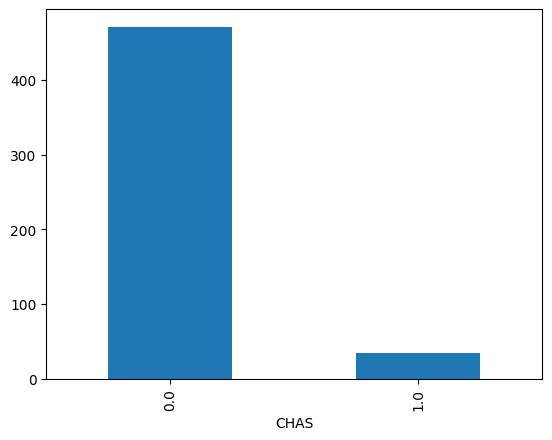

In [97]:
%matplotlib inline
df['CHAS'].value_counts().plot(kind='bar')

Note that the IPython magic command `%matplotlib inline` enables you to view the chart inline.

Let's pull back to the dataset as a whole for a moment. Two major things that you will look for in almost any dataset are trends and relationships. A typical relationship between variables to explore is the Pearson correlation, or the extent to which two variables are linearly related. The `corr` method will show this in table format for all of the columns in a `DataFrame`:

In [98]:
df.corr(method='pearson')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV,AGE_50
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,0.452220,-0.385832,0.254574
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995,0.360445,-0.590769
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800,-0.483725,0.516001
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,-0.053929,0.175260,0.088659
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879,-0.427321,0.597644
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808,0.695360,-0.164465
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339,-0.376955,0.870348
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996,0.249929,-0.673813
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676,-0.381626,0.361191
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,0.543993,-0.468536,0.381395


Suppose you just wanted to look at the correlations between all of the columns and just one variable? Let's examine just the correlation between all other variables and the percentage of owner-occupied houses build before 1940 (AGE). We will do this by accessing the column by index number:

In [99]:
corr = df.corr(method='pearson')
corr_with_homevalue = corr.iloc[-1]
corr_with_homevalue[corr_with_homevalue.argsort()[::-1]]

/var/folders/p1/d1ynn_dj70gb669w1pst351m0000gn/T/ipykernel_90408/1002528811.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corr_with_homevalue[corr_with_homevalue.argsort()[::-1]]


AGE_50     1.000000
AGE        0.870348
NOX        0.597644
INDUS      0.516001
LSTAT      0.468146
TAX        0.381395
RAD        0.361191
CRIM       0.254574
PTRATIO    0.236216
CHAS       0.088659
RM        -0.164465
MEDV      -0.289750
ZN        -0.590769
DIS       -0.673813
Name: AGE_50, dtype: float64

With the correlations arranged in descending order, it's easy to start to see some patterns. Correlating AGE with a variable we created from AGE is a trivial correlation. However, it is interesting to note that the percentage of older housing stock in communities strongly correlates with air pollution (NOX) and the proportion of non-retail business acres per town (INDUS); at least in 1978 metro Boston, older towns are more industrial.

Graphically, we can see the correlations using a heatmap from the Seaborn library:

<Axes: >

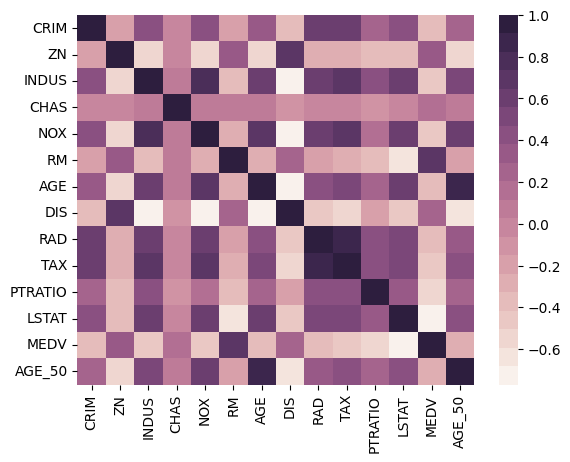

In [100]:
import seaborn as sns
sns.heatmap(df.corr(),cmap=sns.cubehelix_palette(20, light=0.95, dark=0.15))

Histograms are another valuable tool for investigating your data. For example, what is the overall distribution of prices of owner-occupied houses in the Boston area?

(array([ 21.,  55.,  82., 154.,  84.,  41.,  30.,   8.,  10.,  21.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <BarContainer object of 10 artists>)

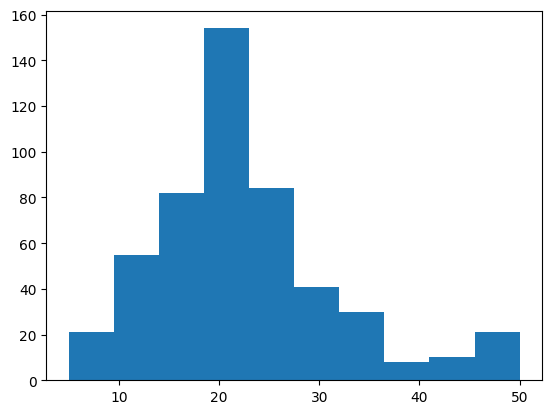

In [101]:
import matplotlib.pyplot as plt
plt.hist(df['MEDV'])

The default bin size for the matplotlib histogram (essentially big of buckets of percentages that you include in each histogram bar in this case) is pretty large and might mask smaller details. To get a finer-grained view of the AGE column, you can manually increase the number of bins in the histogram:

(array([ 3.,  1.,  7.,  7.,  3.,  6.,  8., 10.,  8., 23., 15., 19., 14.,
        16., 18., 28., 36., 29., 33., 28., 37., 21., 15.,  4.,  7., 11.,
         9.,  9.,  5.,  7.,  7.,  8.,  2.,  8.,  5.,  4.,  2.,  1.,  1.,
         0.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  0.,  3., 16.]),
 array([ 5. ,  5.9,  6.8,  7.7,  8.6,  9.5, 10.4, 11.3, 12.2, 13.1, 14. ,
        14.9, 15.8, 16.7, 17.6, 18.5, 19.4, 20.3, 21.2, 22.1, 23. , 23.9,
        24.8, 25.7, 26.6, 27.5, 28.4, 29.3, 30.2, 31.1, 32. , 32.9, 33.8,
        34.7, 35.6, 36.5, 37.4, 38.3, 39.2, 40.1, 41. , 41.9, 42.8, 43.7,
        44.6, 45.5, 46.4, 47.3, 48.2, 49.1, 50. ]),
 <BarContainer object of 50 artists>)

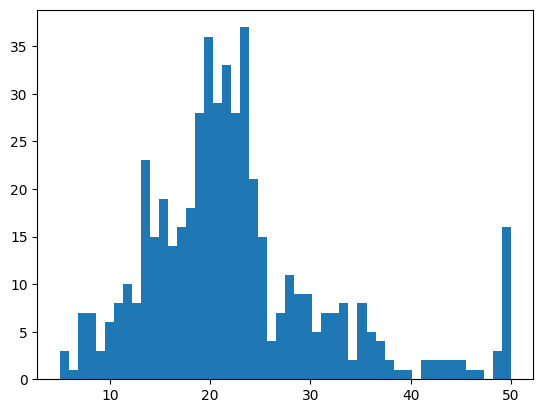

In [102]:
plt.hist(df['MEDV'],bins=50)

Seaborn has a somewhat more attractive version of the standard matplotlib histogram: the distribution plot. This is a combination histogram and kernel density estimate (KDE) plot (essentially a smoothed histogram):

/var/folders/p1/d1ynn_dj70gb669w1pst351m0000gn/T/ipykernel_90408/2300814841.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['MEDV'])


<Axes: xlabel='MEDV', ylabel='Density'>

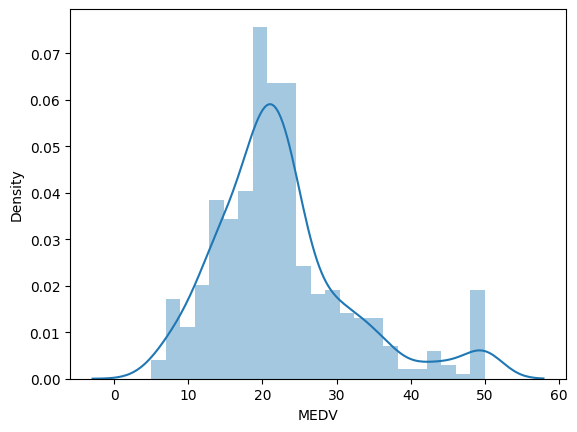

In [103]:
sns.distplot(df['MEDV'])

Another commonly used plot is the Seaborn jointplot, which combines histograms for two columns along with a scatterplot:

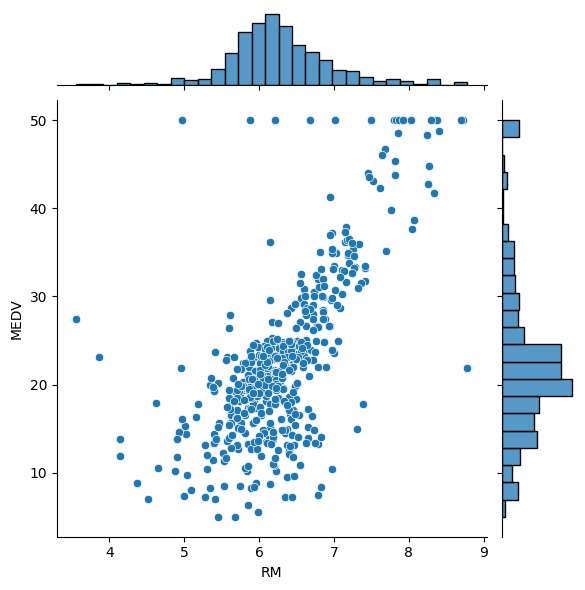

In [104]:
sns.jointplot(data = df, x=df['RM'], y=df['MEDV'], kind='scatter')

Unfortunately, many of the dots print over each other. You can help address this by adding some alpha blending, a figure that sets the transparency for the dots so that concentrations of them drawing over one another will be apparent:

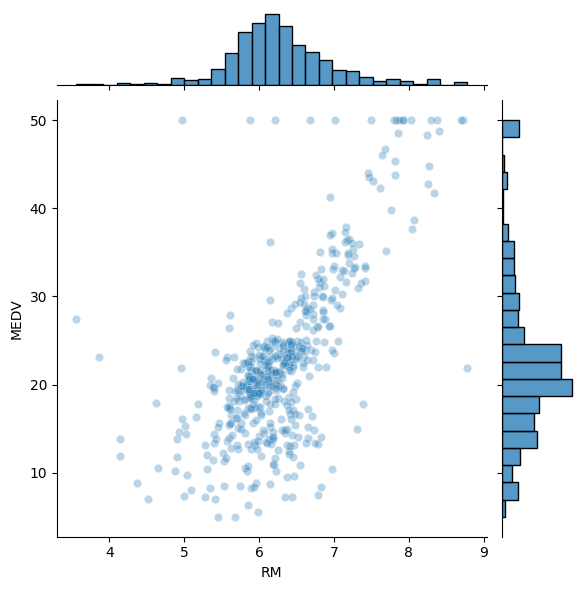

In [105]:
sns.jointplot(data = df, x = df['RM'], y = df['MEDV'], kind='scatter', alpha=0.3)

Another way to see patterns in your data is with a two-dimensional KDE plot. Darker colors here represent a higher concentration of data points:

/var/folders/p1/d1ynn_dj70gb669w1pst351m0000gn/T/ipykernel_90408/2912070.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = df['RM'], y = df['MEDV'], shade=True)


<Axes: xlabel='RM', ylabel='MEDV'>

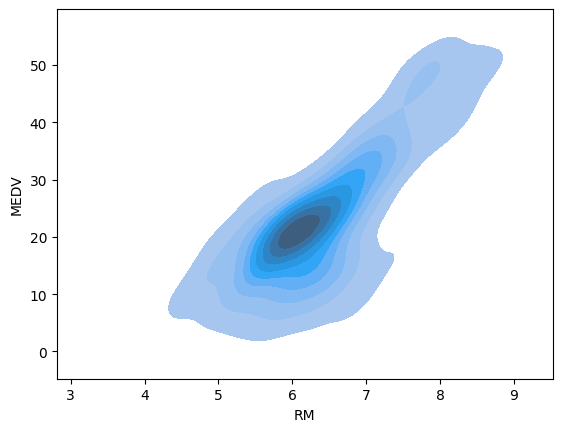

In [107]:
sns.kdeplot(data = df, x = df['RM'], y = df['MEDV'], shade=True)

Note that while the KDE plot is very good at showing concentrations of data points, finer structures like linear relationships (such as the clear relationship between the number of rooms in homes and the house price) are lost in the KDE plot.

Finally, the pairplot in Seaborn allows you to see scatterplots and histograms for several columns in one table. Here we have played with some of the keywords to produce a more sophisticated and easier to read pairplot that incorporates both alpha blending and linear regression lines for the scatterplots.

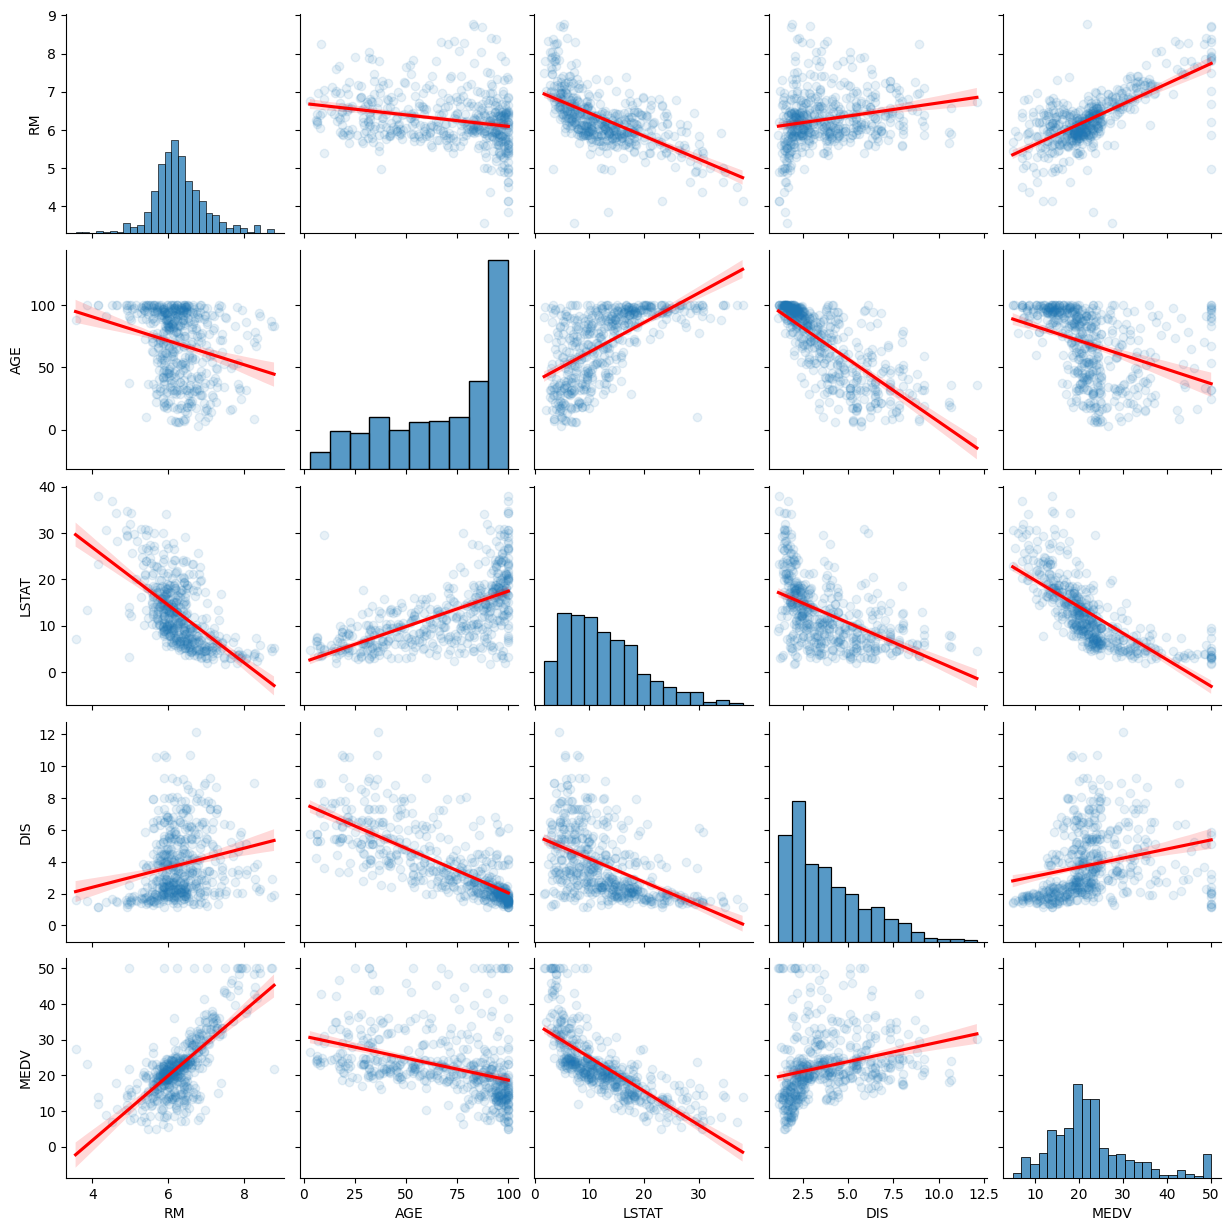

In [108]:
sns.pairplot(df[['RM', 'AGE', 'LSTAT', 'DIS', 'MEDV']], kind="reg", plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

Visualization is the start of the really cool, fun part of data science. So play around with these visualization tools and see what you can learn from the data!

> **Takeaway:** Visualization is often the key to finding patterns and correlations in your data. While visualization cannot often deliver precise results, it can point you in the right direction to ask better questions and efficiently find value in the data.